<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Author: Unknown_

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# often necessary b/c pandas & statsmodels datetime issue
import warnings
warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [2]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [3]:
walmart.isnull().sum()
# No NaN

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [4]:
walmart.info()
# Check there is bool and object column in our data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [18]:
# Observe on 143 days
walmart.Date.nunique()

143

In [16]:
# How many store?
walmart['Store'].nunique()

45

In [20]:
# How mant department?
walmart['Dept'].nunique()

81

**Creating a datetime index**

Convert the `Date` column to datetime, and set it as the index for the dataframe.

In [21]:
walmart['Date'] = pd.to_datetime(walmart['Date'])

In [22]:
walmart.set_index('Date',inplace=True)
walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **groupby**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [35]:
store_1 = walmart.groupby(['Store','Date']).sum().loc[1][['Weekly_Sales']]

In [37]:
store_1.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

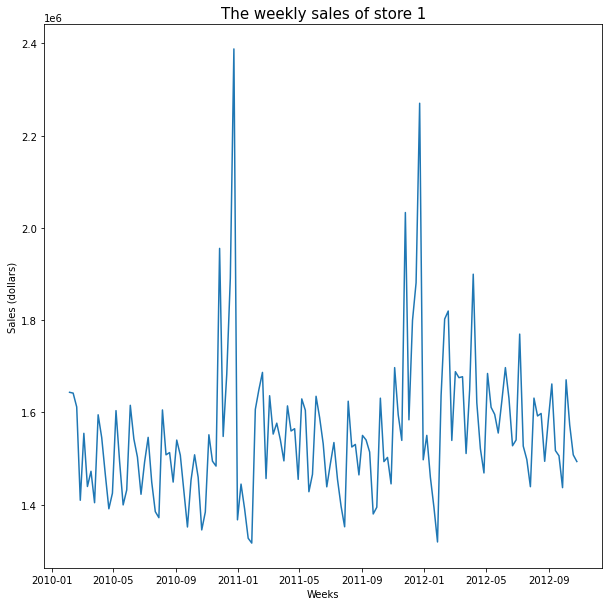

In [42]:
plt.figure(figsize=(10,10))
plt.plot(store_1)
plt.title('The weekly sales of store 1',fontsize= 15)
plt.xlabel('Weeks')
plt.ylabel('Sales (dollars)');

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

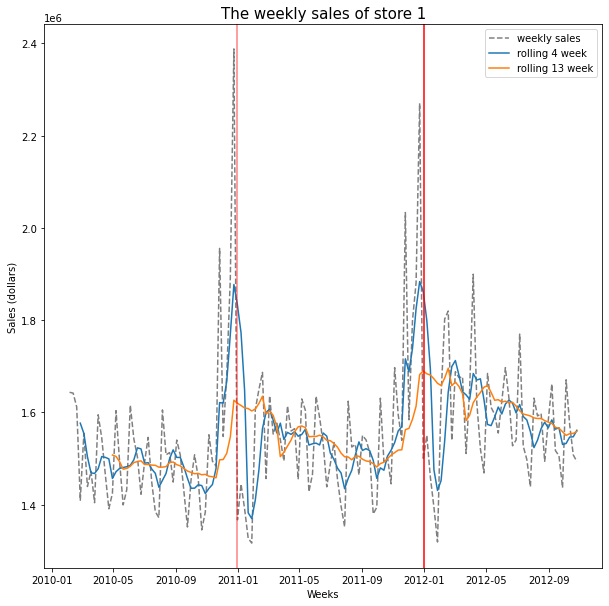

In [94]:
plt.figure(figsize=(10,10))
plt.plot(store_1,linestyle= '--',color = 'k',alpha =0.5,label='weekly sales')
plt.plot(store_1.rolling(window=4).mean(),label = 'rolling 4 week')
plt.plot(store_1.rolling(window=13).mean(),label = 'rolling 13 week')
plt.axvline(store_1.resample('Q').sum().loc[['2011-12-31']].index,color='r')
plt.axvline(store_1.resample('Q').sum().loc[['2010-12-31']].index,color='r',alpha=0.5)

plt.title('The weekly sales of store 1',fontsize= 15)
plt.xlabel('Weeks')
plt.ylabel('Sales (dollars)')
plt.legend();

**Describe any trends that you notice**

In [2]:
# A: The Sales of store 1 seem to rapidly increase by the end of the year during the new year festival. 
# Also, the sales rate tend to slightly increase from the October until 1st of January.

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

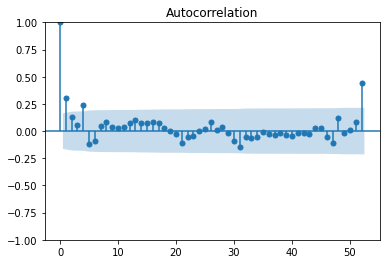

In [96]:
plot_acf(store_1,lags=52);

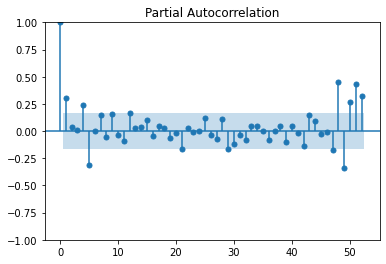

In [100]:
plot_pacf(store_1,lags=52);

In [107]:
# A: From the acf plot, there is positive value between the lag of 0 and 1, so that mean there is a trend in the data.
# There is a significant amount of the variance at week 52th, got some peak of correlation. We should include into the model.
# The 

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [101]:
train_data,test_data = train_test_split(store_1,shuffle=False,test_size=0.1)

In [102]:
train_data.shape,test_data.shape

((128, 1), (15, 1))

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [105]:
print(f'The test statistic: {adfuller(store_1)[0]}')
print(f'The p-value: {adfuller(store_1)[1]}')
adfuller()
# test statistic is negative, also p-value is less than 0.05 (at 95% confidence interval)

The test statistic: -5.1021861451922845
The p-value: 1.3877788330759666e-05


---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [108]:
ar = ARIMA(endog=train_data,order=(1,0,0))
model = ar.fit()

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of `start` and `end` dates.

Generate and store predictions for the training and testing data.

In [115]:
train_pred = model.predict(start=train_data.index[0],end=train_data.index[-1])
test_pred= model.predict(start = test_data.index[0],end=test_data.index[-1])

**Mean squared error**

Use the `mean_squared_error` function to identify the MSE on the testing data.

In [116]:
mean_squared_error(test_data,test_pred)

5188882502.605215

**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


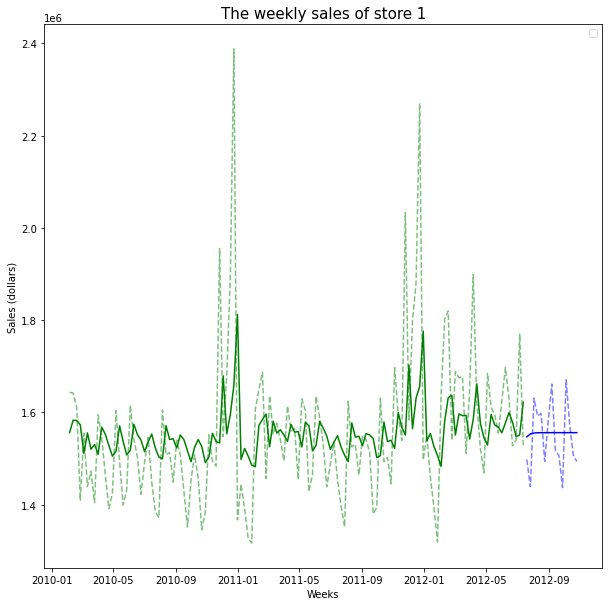

In [125]:
plt.figure(figsize=(10,10))

plt.plot(train_data,color='g',linestyle='--',alpha=0.5)
plt.plot(test_data,color='b',linestyle='--',alpha=0.5)
plt.plot(train_pred,color='g')
plt.plot(test_pred,color='b')



plt.title('The weekly sales of store 1',fontsize= 15)
plt.xlabel('Weeks')
plt.ylabel('Sales (dollars)')
plt.legend();

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

- Without consider on I and  MA paramater,also the lag with 1 could give the prediction converge to mean value which mean the prediction not really good


---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [126]:
ar = ARIMA(endog=train_data,order=(2,0,2))
model = ar.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [127]:
train_pred = model.predict(start=train_data.index[0],end=train_data.index[-1])
test_pred= model.predict(start = test_data.index[0],end=test_data.index[-1])

**Mean squared error**

Find the MSE of the testing data.

In [128]:
mean_squared_error(test_data,test_pred)

4617980198.059827

**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


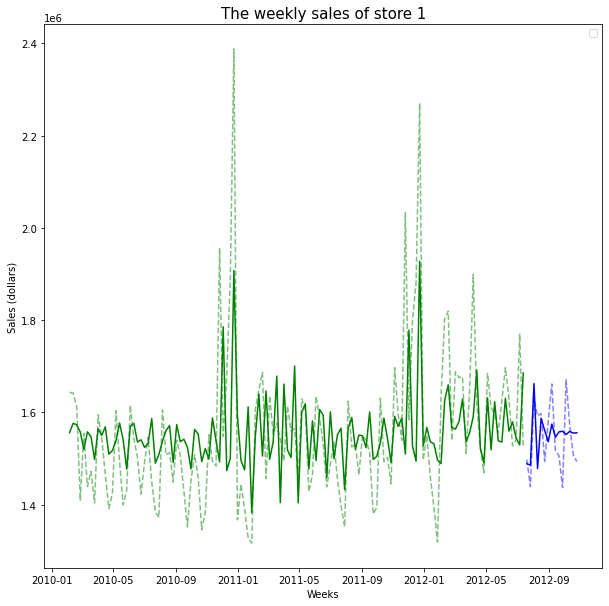

In [129]:
plt.figure(figsize=(10,10))

plt.plot(train_data,color='g',linestyle='--',alpha=0.5)
plt.plot(test_data,color='b',linestyle='--',alpha=0.5)
plt.plot(train_pred,color='g')
plt.plot(test_pred,color='b')



plt.title('The weekly sales of store 1',fontsize= 15)
plt.xlabel('Weeks')
plt.ylabel('Sales (dollars)')
plt.legend();

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [3]:
# A: The model work better than the previous case. After consider the lag of 2, the error term of 2 and
# without differentiate term.

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [130]:
ar = ARIMA(endog=train_data,order=(2,1,2))
model = ar.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [131]:
train_pred = model.predict(start=train_data.index[0],end=train_data.index[-1])
test_pred= model.predict(start = test_data.index[0],end=test_data.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [132]:
mean_squared_error(test_data,test_pred)

8383610308.901479

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


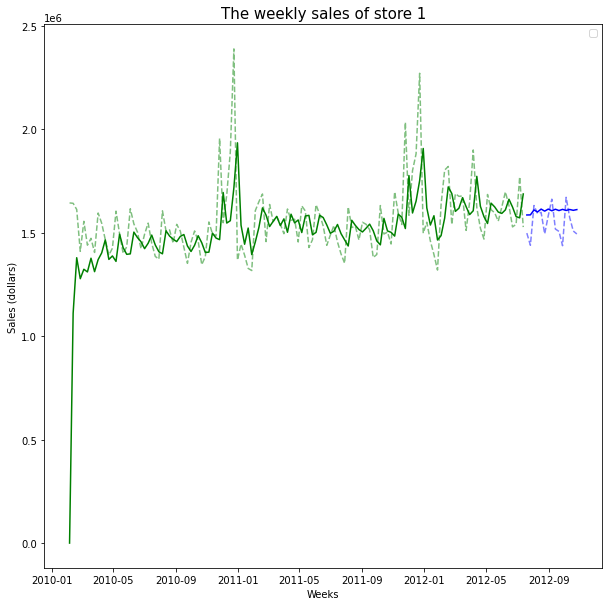

In [133]:
plt.figure(figsize=(10,10))

plt.plot(train_data,color='g',linestyle='--',alpha=0.5)
plt.plot(test_data,color='b',linestyle='--',alpha=0.5)
plt.plot(train_pred,color='g')
plt.plot(test_pred,color='b')



plt.title('The weekly sales of store 1',fontsize= 15)
plt.xlabel('Weeks')
plt.ylabel('Sales (dollars)')
plt.legend();

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [5]:
# A:The model work worse after adding the difference term to 1, 
# even the prediction of training set is clearly see the pattern. But the prediction on testing  converge to one value.

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [134]:
ar = ARIMA(endog=train_data,order=(52,0,1))
model = ar.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [135]:
train_pred = model.predict(start=train_data.index[0],end=train_data.index[-1])
test_pred= model.predict(start = test_data.index[0],end=test_data.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [136]:
mean_squared_error(test_data,test_pred)

7894232076.355178

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


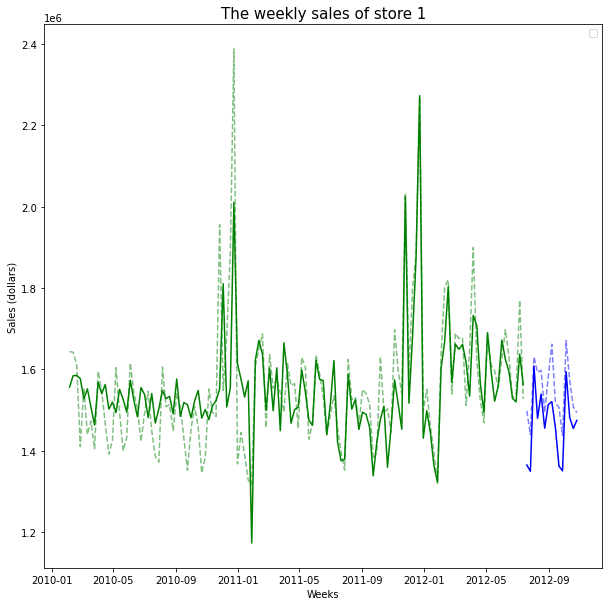

In [137]:
plt.figure(figsize=(10,10))

plt.plot(train_data,color='g',linestyle='--',alpha=0.5)
plt.plot(test_data,color='b',linestyle='--',alpha=0.5)
plt.plot(train_pred,color='g')
plt.plot(test_pred,color='b')



plt.title('The weekly sales of store 1',fontsize= 15)
plt.xlabel('Weeks')
plt.ylabel('Sales (dollars)')
plt.legend();

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [4]:
# A: The lag of 52 seem better than previous, 
# but it is still not capture the pattern very well maybe it's overfitting and still can't beat the (2,0,2) case.
# Because there is some suspect sudden shock in the plots, also the acf plot show that at 
# lags of 1 to 2 is sharply decrease the correlation

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

In [146]:
sa = SARIMAX(endog=train_data,order=(2,0,2),seasonal_order=(1,1,1,52))
model = sa.fit(disp=0)
train_pred = model.predict(start=train_data.index[0],end=train_data.index[-1])
test_pred= model.predict(start = test_data.index[0],end=test_data.index[-1])
mean_squared_error(test_data,test_pred)

1888738697.9953284

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


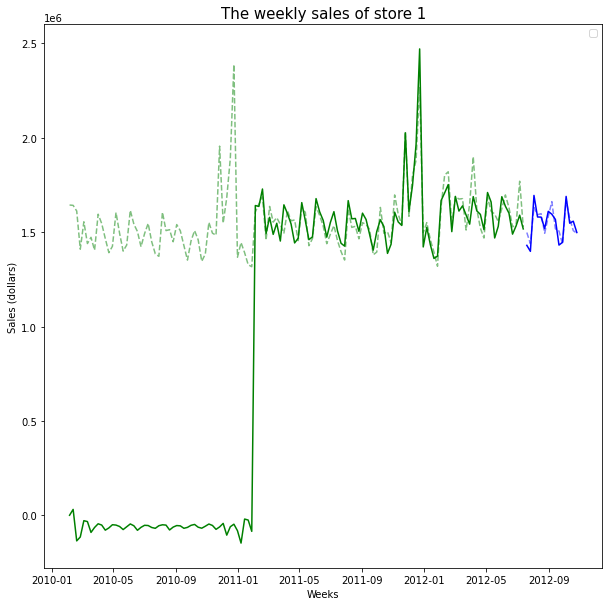

In [147]:
plt.figure(figsize=(10,10))

plt.plot(train_data,color='g',linestyle='--',alpha=0.5)
plt.plot(test_data,color='b',linestyle='--',alpha=0.5)
plt.plot(train_pred,color='g')
plt.plot(test_pred,color='b')



plt.title('The weekly sales of store 1',fontsize= 15)
plt.xlabel('Weeks')
plt.ylabel('Sales (dollars)')
plt.legend();

In [ ]:
# The sharply drop before 2011-02 may be because the some of the seasonal parameter, 
# but it make the prediction capture the pattern very well on testing data.